In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define Generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 4, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator class
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Dataset and Dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Hyperparameters
latent_size = 100
hidden_dim = 256
image_size = 28 * 28
num_epochs = 100
batch_size = 64
lr = 0.0002

# Initialize models, loss function, and optimizers
generator = Generator(latent_size, hidden_dim, image_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
discriminator = Discriminator(image_size, hidden_dim, 1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.view(batch_size, -1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        real_labels = torch.ones(batch_size, 1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        fake_labels = torch.zeros(batch_size, 1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Train the Discriminator
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train the Generator
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        # Save losses for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if (i+1) % 200 == 0:

            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

# Save the final trained models
torch.save(generator.state_dict(), 'final_generator.pth')
torch.save(discriminator.state_dict(), 'final_discriminator.pth')



Epoch [1/100], Step [200/938], d_loss: 0.05405395105481148, g_loss: 3.9616599082946777
Epoch [1/100], Step [400/938], d_loss: 0.0341796912252903, g_loss: 7.149845600128174
Epoch [1/100], Step [600/938], d_loss: 0.0076343100517988205, g_loss: 8.60983657836914
Epoch [1/100], Step [800/938], d_loss: 0.17360538244247437, g_loss: 4.872611999511719
Epoch [2/100], Step [200/938], d_loss: 0.056307051330804825, g_loss: 11.523181915283203
Epoch [2/100], Step [400/938], d_loss: 1.7375755310058594, g_loss: 9.267452239990234
Epoch [2/100], Step [600/938], d_loss: 0.16107386350631714, g_loss: 6.522798538208008
Epoch [2/100], Step [800/938], d_loss: 0.47605735063552856, g_loss: 3.1811928749084473
Epoch [3/100], Step [200/938], d_loss: 0.8133195042610168, g_loss: 4.6405029296875
Epoch [3/100], Step [400/938], d_loss: 0.42095375061035156, g_loss: 1.9993479251861572
Epoch [3/100], Step [600/938], d_loss: 0.326480507850647, g_loss: 3.0625381469726562
Epoch [3/100], Step [800/938], d_loss: 0.1797181367874

In [ ]:
import torch
import torch.nn as nn
import h5py
from keras.models import Sequential
from keras.layers import Dense, Activation

# Define your existing trained PyTorch Generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 4, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the trained PyTorch generator model
input_size = 100  # Change as per your input size
hidden_dim = 256  # Change as per your hidden layer size
output_size = 784  # Change as per your output size (28*28 for MNIST)
pytorch_generator = Generator(input_size, hidden_dim, output_size)

# Load the trained weights (update with your path)
pytorch_generator.load_state_dict(torch.load('final_generator.pth'))
pytorch_generator.eval()  # Set to evaluation mode

# Create a Keras model
keras_generator = Sequential()
keras_generator.add(Dense(hidden_dim, input_dim=input_size))
keras_generator.add(Activation('relu'))
keras_generator.add(Dense(hidden_dim * 2))
keras_generator.add(Activation('relu'))
keras_generator.add(Dense(hidden_dim * 4))
keras_generator.add(Activation('relu'))
keras_generator.add(Dense(output_size))
keras_generator.add(Activation('tanh'))

# Transfer weights from PyTorch model to Keras model
with torch.no_grad():
    for layer in range(len(pytorch_generator.model)):
        if isinstance(pytorch_generator.model[layer], nn.Linear):
            # Get weights and biases
            weight = pytorch_generator.model[layer].weight.detach().numpy()
            bias = pytorch_generator.model[layer].bias.detach().numpy()

            # Set the weights and biases in Keras model
            keras_generator.layers[layer].set_weights([weight.T, bias])  # Keras expects shape (n_in, n_out)

# Save the Keras model
keras_generator.save('generator_model.h5')  # Save model as H5 file

# Save model architecture to JSON
model_json = keras_generator.to_json()
with open('generator_model.json', 'w') as json_file:
    json_file.write(model_json)

print("Keras model and architecture saved successfully.")


<ipython-input-7-32bffcab4ae1>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pytorch_generator.load_state_dict(torch.load('final_generator.pth'))
/usr/local/lib/python3.

Keras model and architecture saved successfully.


In [ ]:
# Save the generator model architecture as JSON
# Save the generator model architecture as JSON
# model_json = generator.to_json()  # Convert model to JSON format
# with open('generator.json', 'w') as json_file:
#     json_file.write(model_json)

# # Save the generator model weights as H5
# generator.save_weights('generator.h5')

# Save the final trained models
torch.save(generator.state_dict(), 'final_generator1.pth')
torch.save(discriminator.state_dict(), 'final_discriminator.pth')

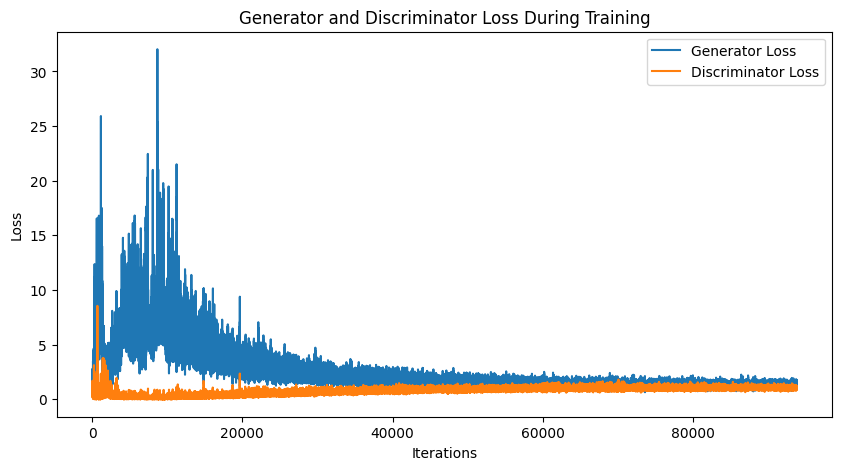

In [ ]:
# Plot the Generator and Discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")
plt.show()

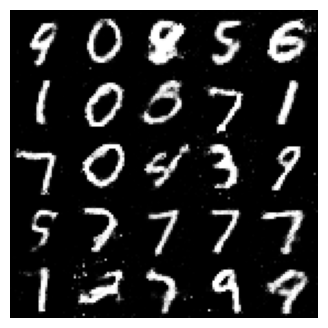

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set the random seed for reproducibility
np.random.seed(504)

# Define parameters for image generation
h = w = 28  # Height and width of the generated images
num_gen = 25  # Number of images to generate
z_dim = 100  # Latent dimension (same as the latent_size in your GAN)

# Generate random noise (latent vectors)
z = np.random.normal(size=[num_gen, z_dim])
z_tensor = torch.tensor(z, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Generate images using your custom Generator
with torch.no_grad():  # No need to track gradients during inference
    generator.eval()  # Set the Generator to evaluation mode
    generated_images = generator(z_tensor).cpu().numpy()

# Plot the generated images in a grid
n = int(np.sqrt(num_gen))
I_generated = np.empty((h * n, w * n))

for i in range(n):
    for j in range(n):
        I_generated[i * h:(i + 1) * h, j * w:(j + 1) * w] = generated_images[i * n + j, :].reshape(28, 28)

# Display the images
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(I_generated, cmap='gray')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define Generator class
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 28 * 28),
            nn.Tanh()  # Normalize the output to range [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img


# Define Discriminator class
class Discriminator2(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Dataset and Dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Hyperparameters
latent_size = 100
hidden_dim = 256
image_size = 28 * 28
num_epochs = 100
batch_size = 64
lr = 0.0002

# Initialize models, loss function, and optimizers
generator = Generator2().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
discriminator = Discriminator2(image_size, hidden_dim, 1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

g_losses = []
d_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.view(batch_size, -1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        real_labels = torch.ones(batch_size, 1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        fake_labels = torch.zeros(batch_size, 1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        # Train the Discriminator
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train the Generator
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        # Save losses for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if (i+1) % 200 == 0:

            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

# Save the final trained models
torch.save(generator.state_dict(), 'final_generator.pth')
torch.save(discriminator.state_dict(), 'final_discriminator.pth')



Epoch [1/100], Step [200/938], d_loss: 0.17896181344985962, g_loss: 6.803108215332031
Epoch [1/100], Step [400/938], d_loss: 0.24689212441444397, g_loss: 27.957660675048828
Epoch [1/100], Step [600/938], d_loss: 0.17995058000087738, g_loss: 25.48816680908203
Epoch [1/100], Step [800/938], d_loss: 0.0726780891418457, g_loss: 32.504547119140625
Epoch [2/100], Step [200/938], d_loss: 0.10711464285850525, g_loss: 15.254913330078125
Epoch [2/100], Step [400/938], d_loss: 0.18418967723846436, g_loss: 8.378884315490723
Epoch [2/100], Step [600/938], d_loss: 0.23959901928901672, g_loss: 8.591233253479004
Epoch [2/100], Step [800/938], d_loss: 0.28695550560951233, g_loss: 4.230096340179443
Epoch [3/100], Step [200/938], d_loss: 0.2660455107688904, g_loss: 6.019515037536621
Epoch [3/100], Step [400/938], d_loss: 0.3431017994880676, g_loss: 5.742350101470947
Epoch [3/100], Step [600/938], d_loss: 0.2804308533668518, g_loss: 6.552033424377441
Epoch [3/100], Step [800/938], d_loss: 0.51267033815383

In [ ]:
import torch
import torch.nn as nn
import h5py
from keras.models import Sequential
from keras.layers import Dense, Activation

# Define your existing trained PyTorch Generator class
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 28 * 28),
            nn.Tanh()  # Normalize the output to range [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img
# Instantiate the trained PyTorch generator model
input_size = 100  # Change as per your input size
hidden_dim = 256  # Change as per your hidden layer size
output_size = 784  # Change as per your output size (28*28 for MNIST)
pytorch_generator = Generator2()

# Load the trained weights (update with your path)
pytorch_generator.load_state_dict(torch.load('final_generator.pth'))
pytorch_generator.eval()  # Set to evaluation mode

# Create a Keras model
keras_generator = Sequential()
keras_generator.add(Dense(hidden_dim, input_dim=input_size))
keras_generator.add(Activation('relu'))
keras_generator.add(Dense(hidden_dim * 2))
keras_generator.add(Activation('relu'))
keras_generator.add(Dense(hidden_dim * 4))
keras_generator.add(Activation('relu'))
keras_generator.add(Dense(output_size))
keras_generator.add(Activation('tanh'))

# Transfer weights from PyTorch model to Keras model
with torch.no_grad():
    keras_layer_index = 0
    for layer in range(len(pytorch_generator.model)):
        if isinstance(pytorch_generator.model[layer], nn.Linear):
            # Get weights and biases
            weight = pytorch_generator.model[layer].weight.detach().numpy()
            bias = pytorch_generator.model[layer].bias.detach().numpy()

            # Set the weights and biases in Keras model
            keras_generator.layers[keras_layer_index].set_weights([weight.T, bias])  # Keras expects shape (n_in, n_out)
            keras_layer_index += 2
# Save the Keras model
keras_generator.save('generator_model2.h5')  # Save model as H5 file

# Save model architecture to JSON
model_json = keras_generator.to_json()
with open('generator_model2.json', 'w') as json_file:
    json_file.write(model_json)

print("Keras model and architecture saved successfully.")


<ipython-input-18-6027703f02dc>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pytorch_generator.load_state_dict(torch.load('final_generator.pth'))
/usr/local/lib/python3

Keras model and architecture saved successfully.


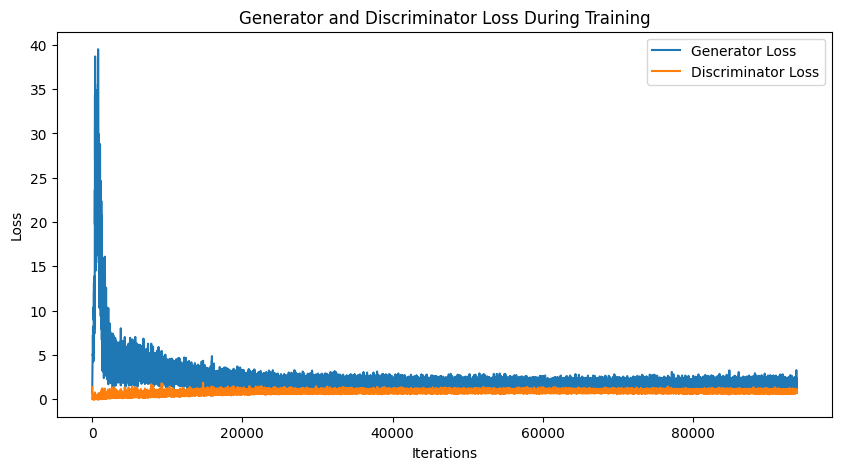

In [ ]:
# Plot the Generator and Discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")
plt.show()

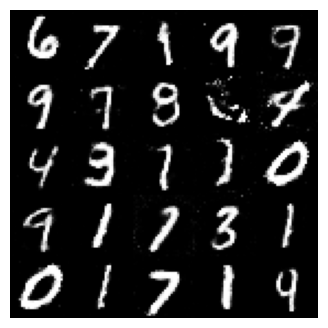

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set the random seed for reproducibility
np.random.seed(504)

# Define parameters for image generation
h = w = 28  # Height and width of the generated images
num_gen = 25  # Number of images to generate
z_dim = 100  # Latent dimension (same as the latent_size in your GAN)

# Generate random noise (latent vectors)
z = np.random.normal(size=[num_gen, z_dim])
z_tensor = torch.tensor(z, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Generate images using your custom Generator
with torch.no_grad():  # No need to track gradients during inference
    generator.eval()  # Set the Generator to evaluation mode
    generated_images = generator(z_tensor).cpu().numpy()

# Plot the generated images in a grid
n = int(np.sqrt(num_gen))
I_generated = np.empty((h * n, w * n))

for i in range(n):
    for j in range(n):
        I_generated[i * h:(i + 1) * h, j * w:(j + 1) * w] = generated_images[i * n + j, :].reshape(28, 28)

# Display the images
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(I_generated, cmap='gray')
plt.show()
